In [1]:
!nvidia-smi

Mon Sep 22 14:56:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.163.01             Driver Version: 550.163.01     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        Off |   00000000:01:00.0  On |                  N/A |
| 30%   42C    P8             23W /  350W |     162MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
try:
    from vllm.distributed.parallel_state import (
        destroy_model_parallel,
        destroy_distributed_environment,
    )
    import vllm
#    !export VLLM_LOGGING_LEVEL=ERROR

    print(f"Successfully imported vllm version: {vllm.__version__}")
    USE_VLLM = True
except ImportError as e:
    print(f"An error occurred: {e}")
    USE_VLLM = False

INFO 09-22 14:56:34 [__init__.py:216] Automatically detected platform cuda.
Successfully imported vllm version: 0.10.2


In [3]:
import torch
import trl
import bitsandbytes

print(f"Using PyTorch version: {torch.__version__}")
print(f"Using TRL version: {trl.__version__}")
print(f"Using bitsandbytes version: {bitsandbytes.__version__}")

Using PyTorch version: 2.8.0+cu128
Using TRL version: 0.22.2
Using bitsandbytes version: 0.47.0


In [ ]:
# Standard library imports
import contextlib
import gc
import json
import logging
import os
import random
import re
import shutil
import sys
import warnings

# Third-party imports
import numpy as np
import pandas as pd
import torch
from datasets import Dataset, load_dataset
from huggingface_hub import login
from peft import LoraConfig
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
from trl import GRPOConfig, GRPOTrainer, SFTConfig, SFTTrainer
from unsloth import FastModel

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/tmp/ipykernel_10394/2303293792.py:8: UserWarning: WARNING: Unsloth should be imported before trl, transformers to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastModel


🦥 Unsloth Zoo will now patch everything to make training faster!


In [5]:
if 'google.colab' in sys.modules:
    from google.colab import userdata
    from huggingface_hub import login

    # Access the secret
    # Make sure you have created a secret named 'HUGGING_FACE_HUB_TOKEN' in your Colab secrets
    hf_token = userdata.get("HF_TOKEN")

    # Log in to Hugging Face
    # The 'token' parameter is used for non-interactive login
    login(token=hf_token)

    print("Hugging Face login successful!")

In [6]:
def silence_annoying_logs():
    """
    Silences INFO and WARNING messages from specific libraries.
    This is a robust method that handles placeholder loggers.
    """
    # List of logger prefixes to silence
    loggers_to_silence = ["vllm", "numba"]  # Added numba as it can also be noisy

    for name, logger in logging.root.manager.loggerDict.items():
        # Check if the logger name starts with any of the prefixes
        if any(name.startswith(prefix) for prefix in loggers_to_silence):
            # IMPORTANT: Check if it's a real logger and not a placeholder
            if isinstance(logger, logging.Logger):
                logger.setLevel(logging.ERROR)


# Also, let's suppress the UserWarning from numba if it appears
warnings.filterwarnings("ignore", category=UserWarning, module="numba")


# Call the function to apply the changes
silence_annoying_logs()

In [ ]:
def clean_log_directory_contents(dir_path):
    """
    Removes all files and subdirectories within the specified directory,
    but not the directory itself.
    """
    if not os.path.isdir(dir_path):
        print(f"Error: Directory '{dir_path}' not found.")
        return

    for item in os.listdir(dir_path):
        item_path = os.path.join(dir_path, item)
        try:
            if os.path.isfile(item_path) or os.path.islink(item_path):
                os.unlink(item_path)
            elif os.path.isdir(item_path):
                shutil.rmtree(item_path)
        except Exception as e:
            print(f"Failed to delete {item_path}. Reason: {e}")


# Specify the directory to clean
log_dir = "logs/grpo-logs"
clean_log_directory_contents(log_dir)
print(f"Contents of '{log_dir}' have been cleaned up.")

In [7]:
# --- System Prompts and Formatting (JSON-Only) ---

# A clear and direct instruction for the AI's role and task.
SYSTEM_PROMPT_HEADER = """You are a financial analyst AI. Your task is to analyze the sentiment of the provided financial news snippet."""

# Specific instructions on the output format.
JSON_STRUCTURE_INSTRUCTIONS = """Your response MUST be only one, valid JSON object containing two keys:
1. `sentiment`: Must be one of "positive", "negative", or "neutral".
2. `explanation`: A brief justification for the sentiment, under 50 words.
After answering the JSON object, stop."""

# A perfect example of the desired output.
EXAMPLE_JSON = """{
  "sentiment": "positive",
  "explanation": "The company announced record profits and a successful product launch, indicating strong positive performance."
}

After generating the single JSON object, stop."""

# Combine all parts into the final system prompt.
SYSTEM_PROMPT = (
    SYSTEM_PROMPT_HEADER
    + "\n\n"
    + JSON_STRUCTURE_INSTRUCTIONS
    + "\n\n"
    + "Here is an example of the required output format:\n"
    + EXAMPLE_JSON
)

In [8]:
# --- Configuration Class ---

class Config:
    """Configuration parameters"""

    SIZE = "3-270m"
    #SIZE = "3-1b"
    MODEL_NAME = f"google/gemma-{SIZE}-it"
    OUTPUT_MODEL = f"gemma-{SIZE}-it-grpo-finsent-json"

    max_prompt_length = 352
    max_completion_length = 100


# --- Environment and Utility Functions ---


def init():
    """Initialization script"""
    os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "0"
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

    # It is recommended to set the HF_TOKEN as an environment variable
    token = os.environ.get("HF_TOKEN")
    if token:
        login(token=token)
    else:
        print("HF_TOKEN not set. You might need to log in manually.")

    torch.cuda.empty_cache()
    gc.collect()
    warnings.filterwarnings("ignore")
    return token


def close(llm=None):
    """Close vllm and clean up resources"""
    destroy_model_parallel()
    destroy_distributed_environment()
    if llm:
        del llm.llm_engine.model_executor
        del llm
    with contextlib.suppress(AssertionError):
        torch.distributed.destroy_process_group()
    gc.collect()
    torch.cuda.empty_cache()


def is_bfloat16_supported():
    """Checks if the current device supports bfloat16."""
    return torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8


def info_device():
    """Get device for PyTorch"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    return device

In [9]:
token = init()
params = Config()
device = info_device()
dtype = torch.bfloat16 if is_bfloat16_supported() else torch.float16

Using device: cuda


In [10]:
def get_fpb_questions(split="train"):
    """Upload FinancialPhraseBank dataset"""
    repo_id = "lmassaron/FinancialPhraseBank"
    data = load_dataset(repo_id, cache_dir="/tmp")[split]

    data = data.map(
        lambda x: {
            "prompt": [
                {"role": "user", "content": SYSTEM_PROMPT + "\n[" + x["sentence"]+"]"},
            ],
            "answer": x["sentiment"],
        }
    )
    data = data.remove_columns(["sentiment", "sentence", "label"])
    return data

Loading tokenizer: google/gemma-3-270m-it

--- Processing 'train' split ---


Tokenizing samples: 100%|██████████| 3872/3872 [00:00<00:00, 7665.77it/s]



--- Processing 'validation' split ---


Tokenizing samples: 100%|██████████| 484/484 [00:00<00:00, 7355.36it/s]



--- Processing 'test' split ---


Tokenizing samples: 100%|██████████| 484/484 [00:00<00:00, 7460.71it/s]



--- Maximum Token Lengths ---
Train Split: 296 tokens
Validation Split: 230 tokens
Test Split: 325 tokens
-----------------------------



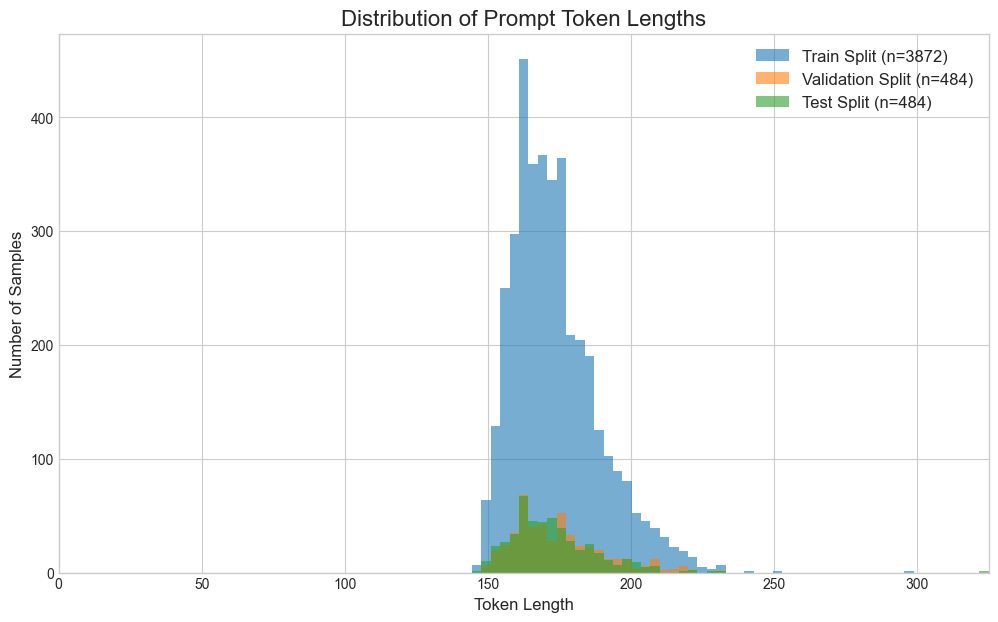

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from transformers import AutoTokenizer

# Assume 'params' and 'get_fpb_questions' are defined and available
# For example:
# from your_utils import get_fpb_questions
# class Params:
#     MODEL_NAME = "google/gemma-2b"
# params = Params()


def analyze_token_lengths(dataset, tokenizer):
    """
    Tokenizes each item in a dataset and returns a list of token lengths.

    Args:
        dataset: A Hugging Face Dataset object.
        tokenizer: An initialized Hugging Face tokenizer.

    Returns:
        A list of integers representing the token length of each prompt.
    """
    token_lengths = []
    # Using tqdm for a nice progress bar, especially for the large training set
    for item in tqdm(dataset, desc="Tokenizing samples"):
        # --- FIX: Extract the actual text from the item dictionary ---
        # Based on your previous code, the prompt is in this nested structure
        prompt_text = item["prompt"][0]["content"]

        # Tokenize the text and get the number of tokens
        # We use .input_ids as it's the most direct way to get the token list
        num_tokens = len(tokenizer(prompt_text).input_ids)
        token_lengths.append(num_tokens)

    return token_lengths


# --- 1. Load Tokenizer ---
print(f"Loading tokenizer: {params.MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(params.MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# --- 2. Analyze all dataset splits ---
splits_to_analyze = ["train", "validation", "test"]
all_token_lengths = {}

for split in splits_to_analyze:
    print(f"\n--- Processing '{split}' split ---")
    # Load the dataset split
    dataset_split = get_fpb_questions(split=split)
    # Analyze and store the token lengths
    all_token_lengths[split] = analyze_token_lengths(dataset_split, tokenizer)

# --- 3. Print Max Token Lengths ---
print("\n--- Maximum Token Lengths ---")
for split, lengths in all_token_lengths.items():
    max_len = np.max(lengths)
    print(f"{split.title()} Split: {max_len} tokens")
print("-----------------------------\n")

# --- 4. Plot Histograms ---
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(12, 7))

# Define bins to make histograms comparable
max_overall_length = max(np.max(lengths) for lengths in all_token_lengths.values())
bins = np.linspace(0, max_overall_length, 100)  # 100 bins up to the max length

for split, lengths in all_token_lengths.items():
    ax.hist(
        lengths,
        bins=bins,
        alpha=0.6,  # Use alpha for transparency to see overlapping distributions
        label=f"{split.title()} Split (n={len(lengths)})",
    )

ax.set_title("Distribution of Prompt Token Lengths", fontsize=16)
ax.set_xlabel("Token Length", fontsize=12)
ax.set_ylabel("Number of Samples", fontsize=12)
ax.legend(fontsize=12)
ax.set_xlim(0, max_overall_length)  # Set x-axis limit
plt.show()

In [12]:
# Let's load a small sample of the GSM8K data to see its structure.
fpb_sample = get_fpb_questions(split="test").select(range(2))

for response in fpb_sample:
    print("--- PROMPT ---")
    print(response["prompt"][0]["content"])
    print("\n--- GROUND TRUTH ANSWER ---")
    print(response["answer"])
    print("=" * 30)

--- PROMPT ---
You are a financial analyst AI. Your task is to analyze the sentiment of the provided financial news snippet.

Your response MUST be only one, valid JSON object containing two keys:
1. `sentiment`: Must be one of "positive", "negative", or "neutral".
2. `explanation`: A brief justification for the sentiment, under 50 words.
After answering the JSON object, stop.

Here is an example of the required output format:
{
  "sentiment": "positive",
  "explanation": "The company announced record profits and a successful product launch, indicating strong positive performance."
}

After generating the single JSON object, stop.
[Loss after taxes amounted to EUR 1.2 mn compared to a loss of 2.6 mn .]

--- GROUND TRUTH ANSWER ---
positive
--- PROMPT ---
You are a financial analyst AI. Your task is to analyze the sentiment of the provided financial news snippet.

Your response MUST be only one, valid JSON object containing two keys:
1. `sentiment`: Must be one of "positive", "negative"

In [13]:
def extract_json_from_text(text: str) -> dict | None:
    """
    Extracts the last JSON object from a string.
    Handles cases where the JSON is embedded in text or code blocks.
    """
    # Regex to find a JSON object, ignoring potential ```json markers
    matches = re.findall(r"\{[\s\S]*?\}", text)
    if not matches:
        return ""
    try:
        # Return the last found JSON object
        return json.loads(matches[-1])
    except json.JSONDecodeError:
        return ""

In [14]:
# --- New Reward Constants (JSON-Only) ---

# Level 1: JSON Format
# Harshest penalty for failing the basic output format.
PENALTY_INVALID_JSON = -2.0
# A small base reward for getting the format right.
REWARD_VALID_JSON = 0.7
# For solving the problem of multiple JSONs
REWARD_SINGLE_JSON = 0.2  # A  positive reward for perfect structure
PENALTY_MULTIPLE_JSONS = -0.6
PENALTY_NO_JSON = -1.2

# Level 2: Core Task Correctness
REWARD_SENTIMENT_CORRECT = 1.0
PENALTY_SENTIMENT_WRONG = -1.0
REWARD_SENTIMENT_NEAR = 0.2  # Encouragement for being close

# Level 3: Quality/Style
REWARD_EXPLANATION_QUALITY = 0.8
MIN_REASONING_LEN = 20
MAX_REASONING_LEN = 50  # Adjusted to match prompt

In [15]:
def flatten(completion):
    if not completion:
        return []
    if isinstance(completion[0], list):
        return [item for sublist in completion for item in sublist]
    return completion

In [16]:
def single_json_reward_func(completions, **kwargs):
    """
    Rewards the model for producing one and only one JSON object.
    This function is the primary enforcer of output structure.
    """
    output = flatten(completions)
    rewards = []
    for response in output:
        # Find all occurrences of JSON-like structures
        matches = re.findall(r"\{[\s\S]*?\}", response["content"])
        num_matches = len(matches)

        if num_matches == 1:
            # The ideal case: exactly one JSON found.
            rewards.append(REWARD_SINGLE_JSON)
        else:
            # 0 or >1 JSONs are both incorrect formats.
            if num_matches == 0:
                rewards.append(PENALTY_NO_JSON)
            else:
                rewards.append(PENALTY_MULTIPLE_JSONS)

    return rewards


def json_format_reward_func(completions, **kwargs):
    """
    Primary gatekeeper. Checks if the output is a valid JSON with the required keys.
    """
    output = flatten(completions)
    rewards = []
    for response in output:
        parsed_json = extract_json_from_text(response["content"])
        if parsed_json and "sentiment" in parsed_json and "explanation" in parsed_json:
            rewards.append(REWARD_VALID_JSON)
        else:
            rewards.append(PENALTY_INVALID_JSON)
    return rewards


def correct_sentiment_func(completions, answer, **kwargs):
    """
    Checks for the correct sentiment within the parsed JSON.
    """
    sentiment_scores = {"positive": 1, "neutral": 0, "negative": -1}
    output = flatten(completions)
    rewards = []
    for response, actual_sentiment in zip(output, answer):
        parsed_json = extract_json_from_text(response["content"])
        if parsed_json and "sentiment" in parsed_json:
            predicted_sentiment = str(parsed_json["sentiment"]).lower()
            if predicted_sentiment in sentiment_scores:
                pred_score = sentiment_scores[predicted_sentiment]
                actual_score = sentiment_scores[actual_sentiment]
                distance = abs(pred_score - actual_score)

                if distance == 0:
                    rewards.append(REWARD_SENTIMENT_CORRECT)
                elif distance == 1:
                    rewards.append(REWARD_SENTIMENT_NEAR)
                else:  # distance == 2
                    rewards.append(PENALTY_SENTIMENT_WRONG)
            else:  # Invalid sentiment value
                rewards.append(PENALTY_SENTIMENT_WRONG)
        else:  # Malformed or missing JSON
            rewards.append(PENALTY_SENTIMENT_WRONG)
    return rewards


def explanation_quality_func(completions, **kwargs):
    """
    Rewards the model for generating an explanation of an ideal length.
    """
    output = flatten(completions)
    rewards = []
    for response in output:
        parsed_json = extract_json_from_text(response["content"])
        if (
            parsed_json
            and "explanation" in parsed_json
            and isinstance(parsed_json["explanation"], str)
        ):
            exp_len = len(parsed_json["explanation"].split())
            if exp_len >= MIN_REASONING_LEN and exp_len <= MAX_REASONING_LEN:
                rewards.append(REWARD_EXPLANATION_QUALITY)
            elif exp_len > 0 and exp_len < MIN_REASONING_LEN:
                rewards.append(
                    REWARD_EXPLANATION_QUALITY * (exp_len / MIN_REASONING_LEN)
                )
            else:
                rewards.append(0.0)  # Too short or too long
        else:
            rewards.append(0.0)  # No quality reward if format is wrong
    return rewards

In [17]:
def test_reward_function(
    model,
    tokenizer,
    test_data,
    num_test_samples,
    device,
    max_visualizations=5,
    temperature=1.0,
    seed=0,
):
    """
    Evaluates the model and reward functions on a random subset of the test data.

    Args:
        model: The model to test.
        tokenizer: The tokenizer for the model.
        test_data: The dataset to sample from.
        num_test_samples: The total number of samples to evaluate.
        device: The device to run inference on.
        max_visualizations (int): The maximum number of detailed outputs to print.
        temperature (float): The generation temperature.
        seed (int): Random seed for reproducibility.
    """
    random.seed(seed)

    # --- Setup for Evaluation and Visualization ---
    random_indices = random.sample(range(len(test_data)), num_test_samples)

    # Randomly select a subset of the test indices to visualize in detail
    # This ensures the visualizations are also a random sample
    visualize_indices = set(
        random.sample(random_indices, k=min(max_visualizations, num_test_samples))
    )

    # --- Data Storage ---
    accuracy_scores = []
    total_rewards = []
    reward_funcs = {
        "json_format": json_format_reward_func,
        "single_json_reward_func": single_json_reward_func,
        "sentiment_correctness": correct_sentiment_func,
        "explanation_quality": explanation_quality_func,
    }
    reward_breakdown = {name: [] for name in reward_funcs.keys()}

    print(
        f"Running evaluation on {num_test_samples} samples. Visualizing {len(visualize_indices)} of them..."
    )

    for i in tqdm(random_indices, desc="Evaluating Samples"):
        sample = test_data[i]
        full_prompt = sample["prompt"][0]["content"]
        ground_truth_sentiment = sample[
            "answer"
        ]  # This is the string "positive", "negative", etc.

        inputs = tokenizer(full_prompt, return_tensors="pt").to(device)

        inputs = tokenizer.apply_chat_template(
            sample["prompt"],
            tokenize=True,
            add_generation_prompt=True,  # Crucial for telling the model it's its turn to speak
            return_tensors="pt",
        ).to(device)

        # Generate a completion from the model
        outputs = model.generate(
            inputs,
            pad_token_id=tokenizer.eos_token_id,
            max_new_tokens=params.max_completion_length,
            temperature=temperature,
            do_sample=True if temperature > 0 else False,
        )

        generated_token_ids = outputs[0, inputs.shape[-1] :]
        generated_text = tokenizer.decode(
            generated_token_ids,
            skip_special_tokens=True,
        ).strip()

        # --- 1. Calculate Accuracy (More Robust Method) ---
        parsed_json = extract_json_from_text(generated_text)
        if parsed_json and isinstance(parsed_json.get("sentiment"), str):
            predicted_sentiment = parsed_json["sentiment"].lower()
            if predicted_sentiment == ground_truth_sentiment:
                accuracy_scores.append(1)
            else:
                accuracy_scores.append(0)
        else:
            accuracy_scores.append(
                0
            )  # If JSON is invalid or sentiment is missing, it's incorrect.

        # --- 2. Calculate Rewards ---
        completions_batch = [[{"content": generated_text}]]
        ground_truth_batch = [ground_truth_sentiment]

        current_rewards = {}
        for name, func in reward_funcs.items():
            # The reward functions return a list with one value, so we extract it.
            reward_value = func(completions_batch, answer=ground_truth_batch)[0]
            current_rewards[name] = reward_value
            reward_breakdown[name].append(reward_value)

        total_reward_for_sample = sum(current_rewards.values())
        total_rewards.append(total_reward_for_sample)

        # --- 3. Visualize a few random samples ---
        if i in visualize_indices:
            print(
                f"\n\n==================== Visualization for Sample Index: {i} ===================="
            )
            print(f"\n>>> Input Text (last 100 chars): ...{full_prompt[-100:]}")
            print(f">>> Ground Truth Sentiment: {ground_truth_sentiment}")
            print(f"\n>>> Model's Raw Output:\n{generated_text}")
            print("\n--- Reward Breakdown ---")
            for name, reward in current_rewards.items():
                print(f"  - {name:<25}: {reward:.2f}")
            print("--------------------------")
            print(f"  - Total Calculated Reward: {total_reward_for_sample:.2f}")
            print(
                "=========================================================================\n"
            )

    # --- Final Aggregate Report ---
    print("\n\n--- Evaluation Summary ---")
    print(f"Sentiment Prediction Accuracy: {np.mean(accuracy_scores):.2%}")
    print(f"Mean Total Reward:             {np.mean(total_rewards):.3f}")
    print("\n--- Average Reward per Function ---")
    for name, scores in reward_breakdown.items():
        mean_score = np.mean(scores)
        # Calculate the percentage of times this reward was positive
        positive_rate = np.mean(np.array(scores) > 0)
        print(f"  - {name:<25}: {mean_score:.3f} (awarded {positive_rate:.1%})")
    print("----------------------------")

In [27]:
TEST = True

if TEST:
    # --- 1. Configuration and Model Loading ---
    print(f"Loading base model: {params.MODEL_NAME} on device: {device}")

    model, tokenizer = FastModel.from_pretrained(
        model_name=params.MODEL_NAME,
        max_seq_length=params.max_prompt_length,  # Choose any for long context!
        load_in_4bit=False,  # 4 bit quantization to reduce memory
        load_in_8bit=False,  # [NEW!] A bit more accurate, uses 2x memory
        full_finetuning=False,  # [NEW!] We have full finetuning now!
        token=token,  # use one if using gated models
    )

    # --- 2. Load Dataset ---
    print("Loading test dataset...")
    fpb_test = get_fpb_questions(split="test")

    # --- 3. Run test ----
    test_reward_function(model, 
                         tokenizer, 
                         test_data=fpb_test, 
                         num_test_samples=150, 
                         device=device,
                         temperature=0.9,
                         seed=0)

    # ---4. Clean up ----
    try:
        del model
        del tokenizer
    except:
        pass

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

Loading base model: google/gemma-3-270m-it on device: cuda
==((====))==  Unsloth 2025.9.7: Fast Gemma3 patching. Transformers: 4.55.4. vLLM: 0.10.2.
   \\   /|    NVIDIA GeForce RTX 3090. Num GPUs = 1. Max memory: 23.682 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 8.6. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = True]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: QLoRA and full finetuning all not selected. Switching to 16bit LoRA.


model.safetensors:   0%|          | 0.00/536M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/233 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/670 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

Loading test dataset...
Running evaluation on 150 samples. Visualizing 5 of them...


Evaluating Samples:   3%|▎         | 5/150 [00:04<01:57,  1.24it/s]



==================== Visualization for Sample Index: 215 ====================

>>> Input Text (last 100 chars): ...ing Kemian Wood Products Co. , Ltd. , which were announced on 3 November 2010 , have taken effect .]
>>> Ground Truth Sentiment: neutral

>>> Model's Raw Output:
```json
{
  "sentiment": "positive",
  "explanation": "The contracts between Raute Corporation and Muling Kemian Wood Products Co. Ltd., which were announced on 3 November 2010 , have taken effect."
}
```

--- Reward Breakdown ---
  - json_format              : 0.70
  - single_json_reward_func  : 0.20
  - sentiment_correctness    : 0.20
  - explanation_quality      : 0.80
--------------------------
  - Total Calculated Reward: 1.90



Evaluating Samples:  33%|███▎      | 49/150 [00:31<01:00,  1.66it/s]



==================== Visualization for Sample Index: 327 ====================

>>> Input Text (last 100 chars): ....
[In the building and home improvement trade , sales decreased by 6.3 % , totalling EUR 154.1 mn .]
>>> Ground Truth Sentiment: negative

>>> Model's Raw Output:
```json
{
  "sentiment": "positive",
  "explanation": "The company's sales performance is positive, suggesting a positive outlook for the company's future."
}
```

--- Reward Breakdown ---
  - json_format              : 0.70
  - single_json_reward_func  : 0.20
  - sentiment_correctness    : -1.00
  - explanation_quality      : 0.56
--------------------------
  - Total Calculated Reward: 0.46



Evaluating Samples:  42%|████▏     | 63/150 [00:39<00:54,  1.60it/s]



==================== Visualization for Sample Index: 363 ====================

>>> Input Text (last 100 chars): ..."
}

After generating the single JSON object, stop.
[Consumption is forecast to grow by about 2 % .]
>>> Ground Truth Sentiment: positive

>>> Model's Raw Output:
```json
{
  "sentiment": "positive",
  "explanation": "The company's projected growth is positive, suggesting continued strong sales and profitability."
}
```

--- Reward Breakdown ---
  - json_format              : 0.70
  - single_json_reward_func  : 0.20
  - sentiment_correctness    : 1.00
  - explanation_quality      : 0.48
--------------------------
  - Total Calculated Reward: 2.38



Evaluating Samples:  47%|████▋     | 70/150 [00:43<00:46,  1.73it/s]



==================== Visualization for Sample Index: 170 ====================

>>> Input Text (last 100 chars): ...SON object, stop.
[Finnish GeoSentric 's net sales decreased to EUR 939,000 in January-March 2009 .]
>>> Ground Truth Sentiment: negative

>>> Model's Raw Output:
```json
{
  "sentiment": "positive",
  "explanation": "Financial news shows a decrease in sales, suggesting a positive trend."
}
```

--- Reward Breakdown ---
  - json_format              : 0.70
  - single_json_reward_func  : 0.20
  - sentiment_correctness    : -1.00
  - explanation_quality      : 0.44
--------------------------
  - Total Calculated Reward: 0.34



Evaluating Samples:  57%|█████▋    | 86/150 [00:53<00:41,  1.56it/s]



==================== Visualization for Sample Index: 260 ====================

>>> Input Text (last 100 chars): ... Construction , Infrastructure Construction , Technical Building Services , and Building Products .]
>>> Ground Truth Sentiment: neutral

>>> Model's Raw Output:
```json
{
  "sentiment": "positive",
  "explanation": "The company's positive outlook on its financial performance is a positive indicator of its continued success."
}
```

--- Reward Breakdown ---
  - json_format              : 0.70
  - single_json_reward_func  : 0.20
  - sentiment_correctness    : 0.20
  - explanation_quality      : 0.64
--------------------------
  - Total Calculated Reward: 1.74



Evaluating Samples: 100%|██████████| 150/150 [01:32<00:00,  1.62it/s]




--- Evaluation Summary ---
Sentiment Prediction Accuracy: 25.33%
Mean Total Reward:             1.671

--- Average Reward per Function ---
  - json_format              : 0.700 (awarded 100.0%)
  - single_json_reward_func  : 0.200 (awarded 100.0%)
  - sentiment_correctness    : 0.235 (awarded 86.0%)
  - explanation_quality      : 0.536 (awarded 100.0%)
----------------------------


In [ ]:
def run_grpo_only_pipeline(model, tokenizer, params, temperature=1.0, debug_mode=False):
    """
    Runs the GRPO fine-tuning pipeline.
    """

    if debug_mode:
        print("--- RUNNING IN DEBUG MODE: Training for a few steps only. ---")

    fpb_train = get_fpb_questions(split="train")
    fpb_eval = get_fpb_questions(split="validation")

    model = FastModel.get_peft_model(
        model,
        finetune_vision_layers=False,  # Turn off for just text!
        finetune_language_layers=True,  # Should leave on!
        finetune_attention_modules=True,  # Attention good for GRPO
        finetune_mlp_modules=True,  # SHould leave on always!
        r=64,  # Larger = higher accuracy, but might overfit
        lora_alpha=128,  # Recommended alpha == r at least
        lora_dropout=0.1,
        bias="none",
        random_state=0,
    )

    training_args = GRPOConfig(
        # --- Core Training Hyperparameters ---
        beta=0.1,
        learning_rate=5e-6,
        adam_beta1=0.9,
        adam_beta2=0.99,
        weight_decay=0.1,
        warmup_ratio=0.1,
        lr_scheduler_type="cosine",
        optim="adamw_torch_fused",
        num_train_epochs=2,
        max_steps=5 if debug_mode else -1,  # Stop after 5 steps in debug mode
        max_grad_norm=0.1,
        # --- Batching & Generation Settings ---
        per_device_train_batch_size=2,  # Smaller for debug
        gradient_accumulation_steps=4,
        num_generations=4,
        temperature=temperature,
        max_prompt_length=params.max_prompt_length,
        max_completion_length=params.max_completion_length,
        generation_kwargs = {'max_length': params.max_completion_length, 'top_p': 0.95},
        # --- Performance & Precision ---
        bf16=is_bfloat16_supported(),
        fp16=not is_bfloat16_supported(),
        gradient_checkpointing=True,
        use_vllm=False,
        vllm_mode="colocate",
        vllm_gpu_memory_utilization=0.30,
        # --- Logging & Saving ---
        output_dir="grpo_training_output",
        report_to="tensorboard",
        logging_dir="logs/grpo-json",
        logging_steps=1 if debug_mode else 100,
        save_strategy="no" if debug_mode else "steps",
        eval_strategy="steps",
        eval_steps=100,  # Evaluate every 100 steps
        save_steps=100,
        save_total_limit=1,  # Only keep the best checkpoint
        load_best_model_at_end=True,  # The trainer will automatically load the best one
    )

    trainer = GRPOTrainer(
        model=model,
        args=training_args,
        train_dataset=fpb_train,
        eval_dataset=fpb_eval,
        # The new, refactored reward functions for the JSON-only task
        reward_funcs=[
            json_format_reward_func,
            # single_json_reward_func,
            correct_sentiment_func,
            explanation_quality_func,
        ],
        processing_class=tokenizer,  # Use processing_class instead of tokenizer
    )

    print("--- Starting GRPO training... ---")
    trainer.train()
    print("--- Training finished. ---")

    # This will print the path to the best checkpoint
    print(
        f"The best model checkpoint was found at: {trainer.state.best_model_checkpoint}"
    )

    print("\nMerging the final model")
    merged_model = trainer.model.merge_and_unload()

    # In debug mode, we don't save the final model
    if not debug_mode:
        lora_output_dir = f"{params.OUTPUT_MODEL}_lora"
        trainer.model.save_pretrained(lora_output_dir)
        print(f"LoRA adapters saved to {lora_output_dir}")
        # Also save the tokenizer with the LoRA adapters for convenience
        tokenizer.save_pretrained(lora_output_dir)

        # Save model and tokenizer
        output_path = f"{params.OUTPUT_MODEL}_grpo"
        print(f"Saving the final model to {output_path}")
        merged_model.save_pretrained(output_path)
        tokenizer.save_pretrained(output_path)

    close()

    return merged_model, tokenizer

In [21]:
print(f"Loading base model: {params.MODEL_NAME} on device: {device}")

model, tokenizer = FastModel.from_pretrained(
    model_name="unsloth/gemma-3-1b-it",
    max_seq_length=params.MODEL_NAME,  # Choose any for long context!
    load_in_4bit=False,  # 4 bit quantization to reduce memory
    load_in_8bit=False,  # [NEW!] A bit more accurate, uses 2x memory
    full_finetuning=False,  # [NEW!] We have full finetuning now!
    token=token,  # use one if using gated models
)

model, tokenizer = run_grpo_only_pipeline(model, tokenizer, params, temperature=0.9, debug_mode=False)

Loading base model: google/gemma-3-270m-it on device: cuda
==((====))==  Unsloth 2025.9.7: Fast Gemma3 patching. Transformers: 4.55.4. vLLM: 0.10.2.
   \\   /|    NVIDIA GeForce RTX 3090. Num GPUs = 1. Max memory: 23.682 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 8.6. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = True]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: QLoRA and full finetuning all not selected. Switching to 16bit LoRA.


Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.1.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.


Unsloth: Making `model.base_model.model.model` require gradients
Unsloth: We now expect `per_device_train_batch_size` to be a multiple of `num_generations`.
We will change the batch size of 2 to the `num_generations` of 4
--- Starting GRPO training... ---


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 3,872 | Num Epochs = 2 | Total steps = 1,936
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 52,183,040 of 1,052,068,992 (4.96% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss,reward,reward_std,completions / mean_length,completions / min_length,completions / max_length,completions / clipped_ratio,completions / mean_terminated_length,completions / min_terminated_length,completions / max_terminated_length,kl,rewards / json_format_reward_func / mean,rewards / json_format_reward_func / std,rewards / correct_sentiment_func / mean,rewards / correct_sentiment_func / std,rewards / explanation_quality_func / mean,rewards / explanation_quality_func / std
100,0.037400,0.008699,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
200,0.096600,0.011602,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log
300,0.316200,0.020680,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log
400,0.135100,0.051434,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log
500,0.268900,0.023721,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log
600,0.223000,0.021220,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log
700,0.187000,0.019706,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log
800,0.167000,0.031640,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log
900,0.191100,0.027924,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log
1000,0.190800,0.039847,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log,No Log


--- Training finished. ---

Merging the final model
LoRA adapters saved to gemma-3-270m-it-grpo-finsent-json_lora
Saving the final model to gemma-3-270m-it-grpo-finsent-json_grpo


In [22]:
# Define the name for your repository on the Hub
repo_name = "lmassaron/" + params.OUTPUT_MODEL

# Push the model to the Hub
model.push_to_hub(repo_name)

# Push the tokenizer to the Hub
tokenizer.push_to_hub(repo_name)

print(f"Model and tokenizer pushed to {repo_name}")

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Saved model to https://huggingface.co/lmassaron/gemma-3-270m-it-grpo-finsent-json


README.md: 0.00B [00:00, ?B/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Model and tokenizer pushed to lmassaron/gemma-3-270m-it-grpo-finsent-json


In [23]:
TEST = True

if TEST:
    # --- 1. Configuration and Model Loading ---
    # Ensure the model is in evaluation mode
    model.eval()

    # Set use_cache to True in the model's configuration
    model.config.use_cache = True 

    # --- 2. Load Dataset ---
    print("Loading test dataset...")
    fpb_test = get_fpb_questions(split="test")

    # --- 3. Run test ----
    test_reward_function(
        model, 
        tokenizer, 
        test_data=fpb_test, 
        num_test_samples=150, 
        device=device, 
        temperature=0.9, 
        seed=0
    )

    # ---4. Clean up ----
    try:
        del model
        del tokenizer
    except:
        pass

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

Loading test dataset...
Running evaluation on 150 samples. Visualizing 5 of them...


Evaluating Samples:   3%|▎         | 5/150 [00:04<02:15,  1.07it/s]



==================== Visualization for Sample Index: 215 ====================

>>> Input Text (last 100 chars): ...ing Kemian Wood Products Co. , Ltd. , which were announced on 3 November 2010 , have taken effect .]
>>> Ground Truth Sentiment: neutral

>>> Model's Raw Output:
```json
{
  "sentiment": "neutral",
  "explanation": "The snippet describes a contractual agreement; it lacks strong positive or negative indicators."
}
```

--- Reward Breakdown ---
  - json_format              : 0.70
  - single_json_reward_func  : 0.20
  - sentiment_correctness    : 1.00
  - explanation_quality      : 0.52
--------------------------
  - Total Calculated Reward: 2.42



Evaluating Samples:  33%|███▎      | 49/150 [00:46<01:32,  1.09it/s]



==================== Visualization for Sample Index: 327 ====================

>>> Input Text (last 100 chars): ....
[In the building and home improvement trade , sales decreased by 6.3 % , totalling EUR 154.1 mn .]
>>> Ground Truth Sentiment: negative

>>> Model's Raw Output:
```json
{
  "sentiment": "negative",
  "explanation": "The decline in sales, coupled with the significant financial loss, suggests a challenging market situation and potential problems for the company."
}
```

--- Reward Breakdown ---
  - json_format              : 0.70
  - single_json_reward_func  : 0.20
  - sentiment_correctness    : 1.00
  - explanation_quality      : 0.80
--------------------------
  - Total Calculated Reward: 2.70



Evaluating Samples:  42%|████▏     | 63/150 [00:58<01:19,  1.09it/s]



==================== Visualization for Sample Index: 363 ====================

>>> Input Text (last 100 chars): ..."
}

After generating the single JSON object, stop.
[Consumption is forecast to grow by about 2 % .]
>>> Ground Truth Sentiment: positive

>>> Model's Raw Output:
```json
{
  "sentiment": "positive",
  "explanation": "The forecast of growth in consumption suggests optimism about the company's future financial prospects."
}
```

--- Reward Breakdown ---
  - json_format              : 0.70
  - single_json_reward_func  : 0.20
  - sentiment_correctness    : 1.00
  - explanation_quality      : 0.56
--------------------------
  - Total Calculated Reward: 2.46



Evaluating Samples:  47%|████▋     | 70/150 [01:05<01:11,  1.12it/s]



==================== Visualization for Sample Index: 170 ====================

>>> Input Text (last 100 chars): ...SON object, stop.
[Finnish GeoSentric 's net sales decreased to EUR 939,000 in January-March 2009 .]
>>> Ground Truth Sentiment: negative

>>> Model's Raw Output:
```json
{
  "sentiment": "negative",
  "explanation": "The decline in net sales suggests potential financial difficulties or challenges for the company, leading to a negative outlook."
}
```

--- Reward Breakdown ---
  - json_format              : 0.70
  - single_json_reward_func  : 0.20
  - sentiment_correctness    : 1.00
  - explanation_quality      : 0.76
--------------------------
  - Total Calculated Reward: 2.66



Evaluating Samples:  57%|█████▋    | 86/150 [01:20<00:57,  1.11it/s]



==================== Visualization for Sample Index: 260 ====================

>>> Input Text (last 100 chars): ... Construction , Infrastructure Construction , Technical Building Services , and Building Products .]
>>> Ground Truth Sentiment: neutral

>>> Model's Raw Output:
```json
{
  "sentiment": "positive",
  "explanation": "The news highlights significant growth in the group's business sectors, suggesting successful operations and positive market performance."
}
```

--- Reward Breakdown ---
  - json_format              : 0.70
  - single_json_reward_func  : 0.20
  - sentiment_correctness    : 0.20
  - explanation_quality      : 0.68
--------------------------
  - Total Calculated Reward: 1.78



Evaluating Samples: 100%|██████████| 150/150 [02:20<00:00,  1.07it/s]




--- Evaluation Summary ---
Sentiment Prediction Accuracy: 57.33%
Mean Total Reward:             2.221

--- Average Reward per Function ---
  - json_format              : 0.700 (awarded 100.0%)
  - single_json_reward_func  : 0.200 (awarded 100.0%)
  - sentiment_correctness    : 0.587 (awarded 94.0%)
  - explanation_quality      : 0.735 (awarded 100.0%)
----------------------------


Searching for TensorBoard event file in: /home/lmassaron/code/sft-workshop/logs/grpo-json
Found event file: logs/grpo-json/events.out.tfevents.1758471506.swordfish-IV.14988.0


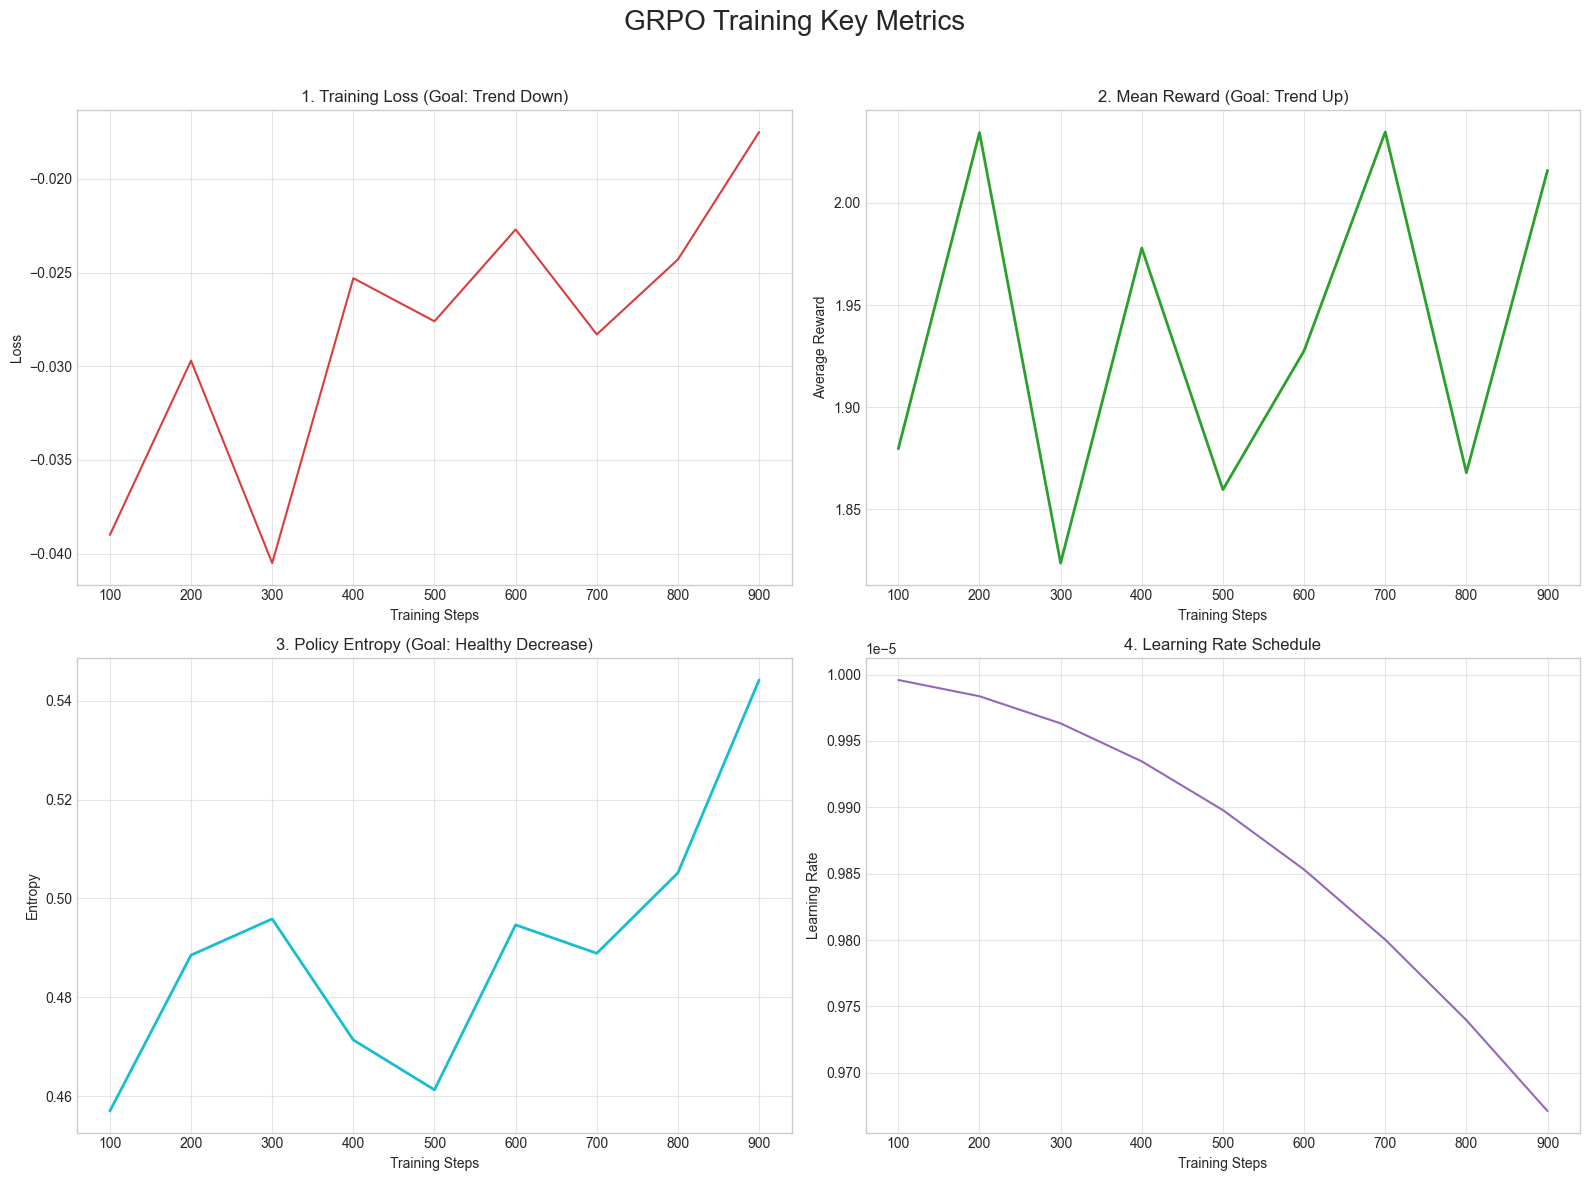

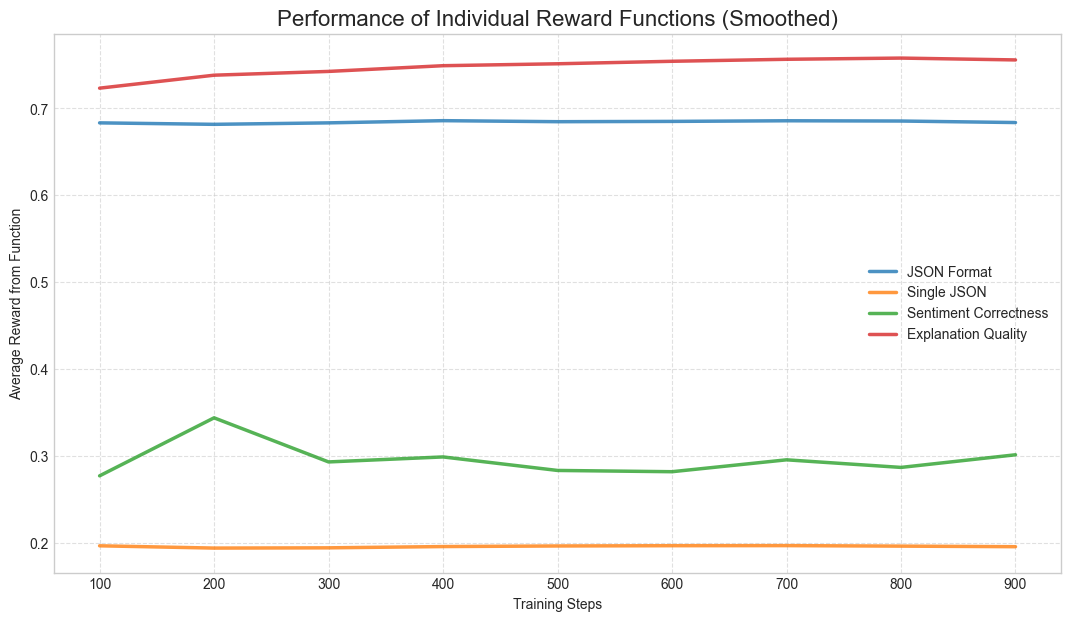

In [25]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorboard.backend.event_processing import event_accumulator

# --- Configuration ---
LOG_DIR = "logs/grpo-json"

REWARD_METRIC_MAPPING = {
    "train/rewards/json_format_reward_func/mean": "JSON Format",
    "train/rewards/single_json_reward_func/mean": "Single JSON",
    "train/rewards/correct_sentiment_func/mean": "Sentiment Correctness",
    "train/rewards/explanation_quality_func/mean": "Explanation Quality",
}


# --- Helper Function to Load TensorBoard Data ---
def load_tensorboard_logs(log_dir):
    """Loads all scalar data from a TensorBoard log directory into pandas DataFrames."""
    data = {}
    event_file = None
    print(f"Searching for TensorBoard event file in: {os.path.abspath(log_dir)}")
    for root, dirs, files in os.walk(log_dir):
        for file in files:
            if "events.out.tfevents" in file:
                event_file = os.path.join(root, file)
                break
    if not event_file:
        print(f"\n--- ERROR: No TensorBoard event file found in '{log_dir}'. ---\n")
        return None

    print(f"Found event file: {event_file}")
    accumulator = event_accumulator.EventAccumulator(
        event_file, size_guidance={"scalars": 0}
    )
    accumulator.Reload()
    tags = accumulator.Tags()["scalars"]
    for tag in tags:
        events = accumulator.Scalars(tag)
        data[tag] = pd.DataFrame(
            {"step": [e.step for e in events], "value": [e.value for e in events]}
        )
    return data


# --- Load the Data ---
log_data = load_tensorboard_logs(LOG_DIR)

if log_data:
    # --- Plotting the Key Metrics ---
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle("GRPO Training Key Metrics", fontsize=20)

    # Plot 1: Training Loss
    if "train/loss" in log_data:
        ax = axs[0, 0]
        df = log_data["train/loss"]
        ax.plot(df["step"], df["value"], color="tab:red", alpha=0.9)
        ax.set_title("1. Training Loss (Goal: Trend Down)")
        ax.grid(True, alpha=0.5)
        ax.set_xlabel("Training Steps")
        ax.set_ylabel("Loss")

    # Plot 2: Mean Reward (Using the correct metric 'train/reward')
    if "train/reward" in log_data:
        ax = axs[0, 1]
        df = log_data["train/reward"]
        ax.plot(df["step"], df["value"], color="tab:green", linewidth=2)
        ax.set_title("2. Mean Reward (Goal: Trend Up)")
        ax.grid(True, alpha=0.5)
        ax.set_xlabel("Training Steps")
        ax.set_ylabel("Average Reward")

    # --- REVISED PLOT 3: Policy Entropy ---
    ax = axs[1, 0]
    if "train/entropy" in log_data:
        df = log_data["train/entropy"]
        ax.plot(df["step"], df["value"], color="tab:cyan", linewidth=2)
        ax.set_title("3. Policy Entropy (Goal: Healthy Decrease)")
        ax.grid(True, alpha=0.5)
        ax.set_xlabel("Training Steps")
        ax.set_ylabel("Entropy")
    else:
        # Fallback if entropy is somehow not in the logs
        ax.text(
            0.5,
            0.5,
            "'train/entropy' not found in log files.",
            ha="center",
            va="center",
            fontsize=12,
            color="gray",
        )
        ax.set_title("3. Policy Entropy")
        ax.set_xticks([])
        ax.set_yticks([])

    # Plot 4: Learning Rate
    if "train/learning_rate" in log_data:
        ax = axs[1, 1]
        df = log_data["train/learning_rate"]
        ax.plot(df["step"], df["value"], color="tab:purple")
        ax.set_title("4. Learning Rate Schedule")
        ax.grid(True, alpha=0.5)
        ax.set_xlabel("Training Steps")
        ax.set_ylabel("Learning Rate")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # --- Plotting Individual Reward Function Performance ---
    plt.figure(figsize=(13, 7))
    plt.title("Performance of Individual Reward Functions (Smoothed)", fontsize=16)

    available_tags = set(log_data.keys())

    # Iterate through our corrected mapping dictionary
    for tag_name, plot_label in REWARD_METRIC_MAPPING.items():
        if tag_name in available_tags:
            df = log_data[tag_name]
            smoothed_value = df["value"].rolling(window=10, min_periods=1).mean()
            plt.plot(
                df["step"], smoothed_value, label=plot_label, linewidth=2.5, alpha=0.8
            )
        else:
            print(
                f"--> Warning: Metric '{tag_name}' for label '{plot_label}' not found in logs. Skipping."
            )

    plt.xlabel("Training Steps")
    plt.ylabel("Average Reward from Function")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()